# Crack Detection and Synthetic Crack Generation

## Overview
This notebook documents the complete process of detecting cracks in images through image segmentation using a Convolutional Neural Network (CNN) and analyzing the results with mathematical regression. Additionally, it generates synthetic binary crack images and solves the inverse problem of fitting functions to describe these cracks.

## Key Sections
1. **Basic Data Visualization and Analysis**
    - Performed exploratory data analysis on the provided crack detection dataset.
    - Visualized several samples, including both images and their corresponding masks.

2. **CNN for Crack Detection (Image Segmentation)**
    - Implemented a CNN model for detecting cracks in asphalt images using segmentation techniques.
    - Trained the model with the provided training dataset and benchmarked using the test dataset.
    - Evaluated the accuracy and performance metrics of the best model.
    - Highlighted potential areas for improvement, including tuning hyperparameters and model architecture.

3. **Mathematical Equation of Cracks (Regression)**
    - Selected three image samples and their respective masks to fit mathematical functions (regression or periodic functions).
    - Described each crack using mathematical equations.
    - Interpreted the regression results and compared the cracks' shapes and properties.

4. **Synthetic Crack Generation**
    - Created 10 synthetic binary images where the line of ones represented cracks, and zeros represented the background.
    - Used mathematical functions such as circles and sine functions to generate the cracks.
    - Explored both single-function and multi-function representations for crack shapes.

5. **Inverse Problem (Fitting Functions to Synthetic Cracks)**
    - Solved the inverse task by fitting mathematical functions to the synthetic cracks generated.
    - Compared the resulting coefficients with the original equations used to generate the cracks.
    - Analyzed the accuracy of the function fitting and discussed any discrepancies or challenges encountered.

## Conclusion
This notebook provides a comprehensive approach to crack detection, mathematical modeling, and synthetic data generation, offering insights into the model's performance and room for future improvement.


In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from src.curve_fit import CurveFit
from src.data_processing import load_images_masks,load_single_image,load_single_mask
from src.synthetic_images import ImageGenerator
from src.visualization import display_image_and_mask,display_test_prediction,plot_training_history
from src.model import simple_unet_model,create_hist
import random
from typing import Dict

2024-10-10 17:01:23.719446: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 17:01:23.719920: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 17:01:23.722409: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 17:01:23.729801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 17:01:23.742492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

### Random seed set to 1 for reproducibility

In [2]:
SEED:int=1
random.seed(SEED)
np.random.seed(SEED)

### Please modify .the paths to match your device.
#### If you use windows do not forget to change the '/' to '\'.

In [3]:
"""Please modify the paths to match your device"""
train_image_dir:str="/home/recabet/Coding/Data/Train/images"
train_mask_dir:str="/home/recabet/Coding/Data/Train/masks"
test_image_dir:str="/home/recabet/Coding/Data/Test/images"
test_mask_dir:str="/home/recabet/Coding/Data/Test/images"

### Loading Data
Used load_images_masks defined in "../Task/src/data/processing.py" to load the test and train data respectively.
The function,takes the respective image and mask directories and a tuple of image size and returns the contents of those directories as a numpy array.

In [4]:
X_train,y_train=load_images_masks(train_image_dir,train_mask_dir)
X_test,y_test=load_images_masks(test_image_dir,test_mask_dir)

### Data insights
As we can see the number of training exmples is almost an order of magnitude higher than the test set.

In [53]:
print(f"Number of training images: {len(X_train)}"
      f"\nNumber of testing images: {len(X_test)}")

Number of training images: 9899
Number of testing images: 1096


<BarContainer object of 2 artists>

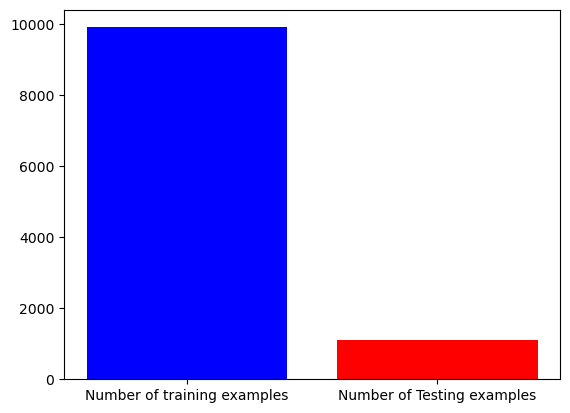

In [5]:
plt.bar(
        ["Number of training examples","Number of Testing examples"],
        [len(X_train),len(X_test)],
        color=["blue","red"]
        )

Calculated the number of white pixels and black pixels of the training masks to get a sense of the average size of cracks with respect to the image size.

In [6]:
white_pixel_count:int = sum([np.sum(i) for i in y_train])
black_pixel_count:int = sum([np.sum(i == 0) for i in y_train])

<BarContainer object of 2 artists>

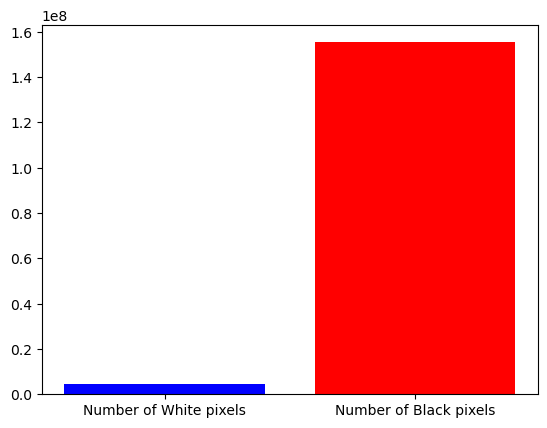

In [7]:
plt.bar(
        ["Number of White pixels", "Number of Black pixels"],
        [white_pixel_count, black_pixel_count],
        color=["blue","red"]
        )

As we can see, the crack is almost 3 percent of the total pixels in an image

In [8]:
avg_crack_density_train:float=white_pixel_count/(white_pixel_count+black_pixel_count)
print(f"The average size of the crack with respect to the size of the image is: {round(avg_crack_density_train,5)}")

The average size of the crack with respect to the size of the image is: 0.02802


### Displaying images
Used the load_single_image and load_single_mask functions also defined in "../Task/src/data_processing.py" to load a single image and mask respectively, it is essentially the same as the load_images_masks function but it only loads a single image or mask, not the full directory.

In [19]:
"""Please modify the paths to match your device"""
image_1_path:str="/home/recabet/Coding/Data/Test/images/CFD_001.jpg"
image_2_path:str="/home/recabet/Coding/Data/Train/images/CFD_002.jpg"
image_3_path:str="/home/recabet/Coding/Data/Train/images/CFD_003.jpg"
image_4_path:str="/home/recabet/Coding/Data/Train/images/CFD_004.jpg"
image_5_path:str="/home/recabet/Coding/Data/Test/images/CFD_005.jpg"
mask_1_path:str="/home/recabet/Coding/Data/Test/masks/CFD_001.jpg"
mask_2_path:str="/home/recabet/Coding/Data/Train/masks/CFD_002.jpg"
mask_3_path:str="/home/recabet/Coding/Data/Train/masks/CFD_003.jpg"
mask_4_path:str="/home/recabet/Coding/Data/Train/masks/CFD_004.jpg"
mask_5_path:str="/home/recabet/Coding/Data/Test/masks/CFD_005.jpg"

In [20]:
image_1=load_single_image(image_1_path)
image_2=load_single_image(image_2_path)
image_3=load_single_image(image_3_path)
image_4=load_single_image(image_4_path)
image_5=load_single_image(image_5_path)
mask_1=load_single_mask(mask_1_path)
mask_2=load_single_mask(mask_2_path)
mask_3=load_single_mask(mask_3_path)
mask_4=load_single_mask(mask_4_path)
mask_5=load_single_mask(mask_5_path)

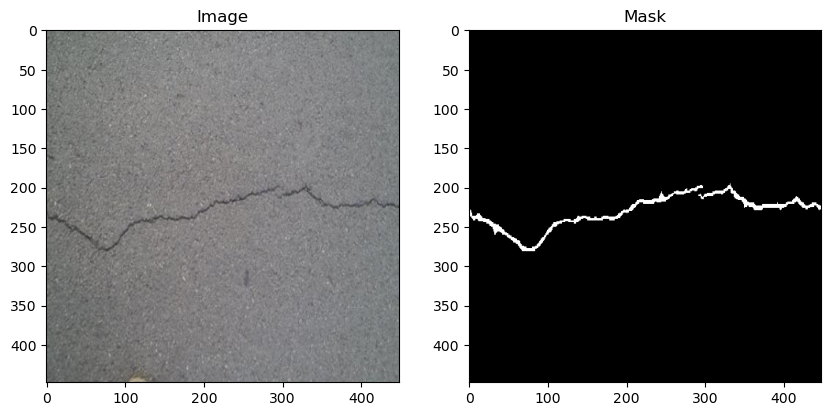

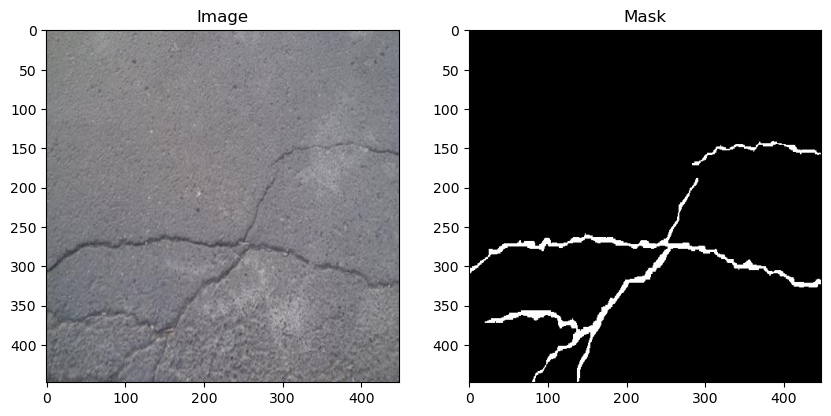

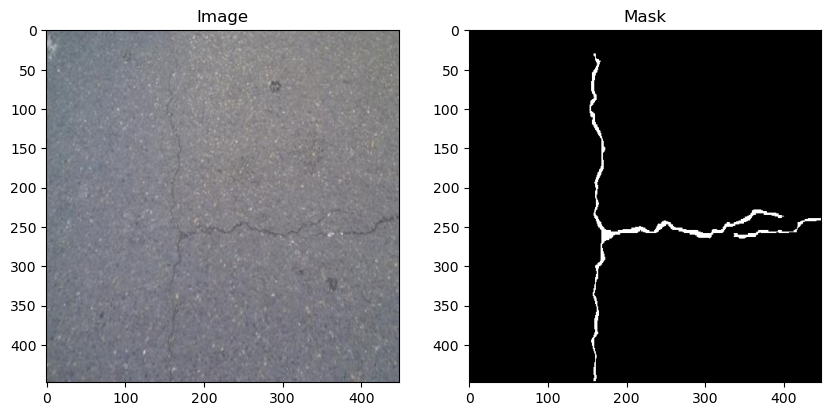

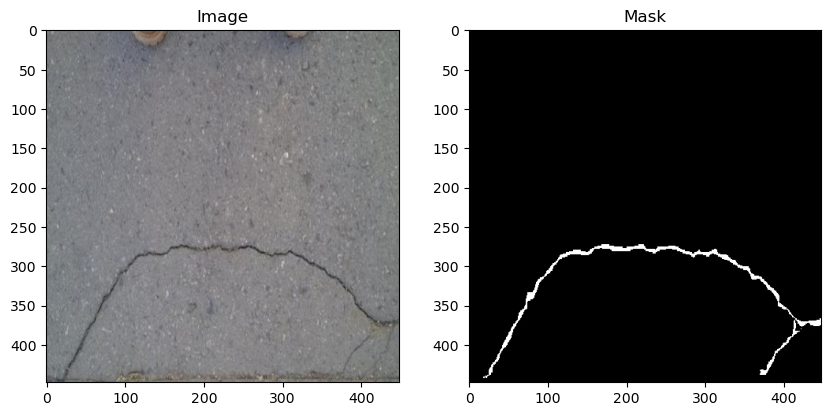

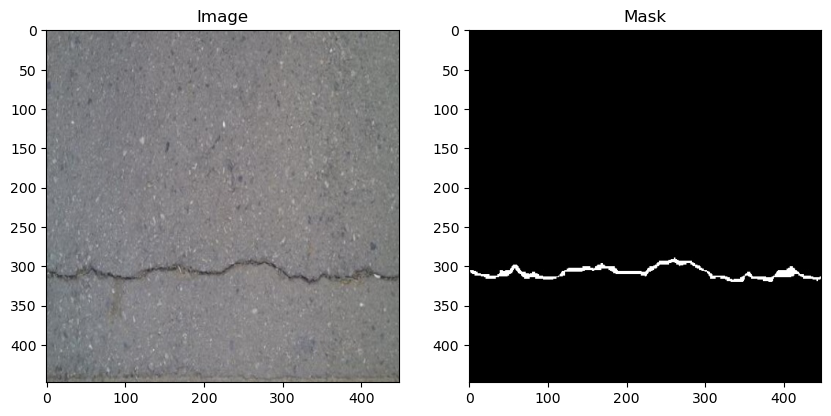

In [10]:
display_image_and_mask(image_1,mask_1)
display_image_and_mask(image_2,mask_2)
display_image_and_mask(image_3,mask_3)
display_image_and_mask(image_4,mask_4)
display_image_and_mask(image_5,mask_5)

### Model training.
Used simple_unet_model defined in "../Task/scr/model.py".
Used callbacks as training time was too much.
Did not use any data generator such as keras.image.ImageDataGenerator as i found it added no real benefits other 
than increasing the training time.
Did not use the complex_unet_model as i found both models to give identical reuslts, minus the training time (12hrs compared to 2 for 10 epochs).

In [12]:
s_unet_no_dg=simple_unet_model()

In [13]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=2)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
callbacks=[reduce_lr,early_stopping]

Found that the lower batch size helps with better IoU.
epochs>10 does not help with anything.

In [14]:
history=create_hist(
                model=s_unet_no_dg,
                X_train= X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
                epochs=10,
                batch_size=1,
                verbose=True,
                validation_split=0.2,
                callbacks=callbacks
                )

Epoch 1/10
7919/7919 ━━━━━━━━━━━━━━━━━━━━ 388s 49ms/step - accuracy: 0.9559 - binary_io_u: 0.5202 - loss: 0.1079 - val_accuracy: 0.9600 - val_binary_io_u: 0.6139 - val_loss: 0.0878 - learning_rate: 0.0010
Epoch 2/10
7919/7919 ━━━━━━━━━━━━━━━━━━━━ 397s 50ms/step - accuracy: 0.9595 - binary_io_u: 0.5934 - loss: 0.0853 - val_accuracy: 0.9614 - val_binary_io_u: 0.6226 - val_loss: 0.0781 - learning_rate: 0.0010
Epoch 3/10
7919/7919 ━━━━━━━━━━━━━━━━━━━━ 448s 57ms/step - accuracy: 0.9599 - binary_io_u: 0.6111 - loss: 0.0817 - val_accuracy: 0.9609 - val_binary_io_u: 0.5944 - val_loss: 0.0834 - learning_rate: 0.0010
Epoch 4/10
7919/7919 ━━━━━━━━━━━━━━━━━━━━ 420s 53ms/step - accuracy: 0.9606 - binary_io_u: 0.6260 - loss: 0.0762 - val_accuracy: 0.9613 - val_binary_io_u: 0.6204 - val_loss: 0.0763 - learning_rate: 0.0010
Epoch 5/10
7919/7919 ━━━━━━━━━━━━━━━━━━━━ 444s 56ms/step - accuracy: 0.9602 - binary_io_u: 0.6255 - loss: 0.0763 - val_accuracy: 0.9617 - val_binary_io_u: 0.6220 - val_loss: 0.0723

In [27]:
s_unet_no_dg.save("../Concrete-Crack-Detection/Models/s_unet_no_dg.keras")

Personally i find the resluts satisfactory as hyperparameter tuning was kept to a minimum (low computational power)
Improvements are only viable if your device can handle the more complex models or intense hyperparameter tuning.

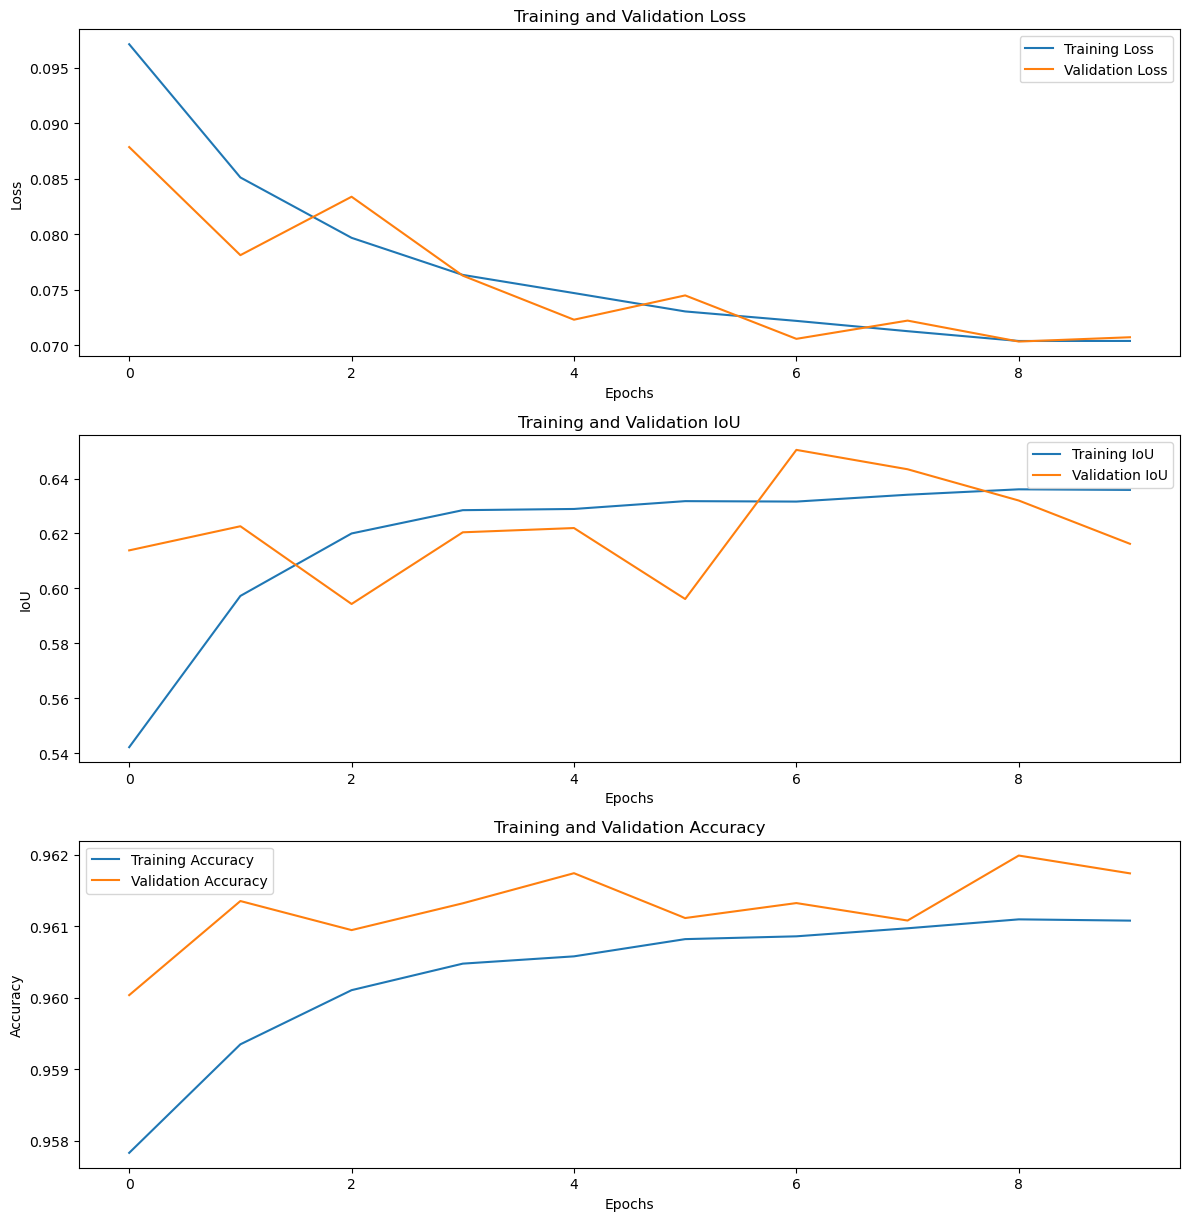

In [28]:
plot_training_history(history)

In [31]:
metrics:Dict[str,float]={
                "loss":np.mean(history.history["loss"][2:]),
                "val_loss":np.mean(history.history["val_loss"][2:]),
                "acc":np.mean(history.history["accuracy"][2:]),
                "val_acc":np.mean(history.history["val_accuracy"][2:]),
                "iou":np.mean(history.history["binary_io_u"][2:]),
                "val_iou":np.mean(history.history["val_binary_io_u"][2:]),
            }

The metrics are looking pretty good.
No signs of overfitting or underfitting.

In [32]:
for key,val in metrics.items():
    print(f"{key}: {round(val,3)}")

loss: 0.073
val_loss: 0.074
acc: 0.961
val_acc: 0.961
iou: 0.631
val_iou: 0.622


In [6]:
predictions=s_unet_no_dg.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 383ms/step


Prediced masks seem reasonable given the IoU score.
More hyperparameter tuning would solve this issue probably, or a different model althogether.

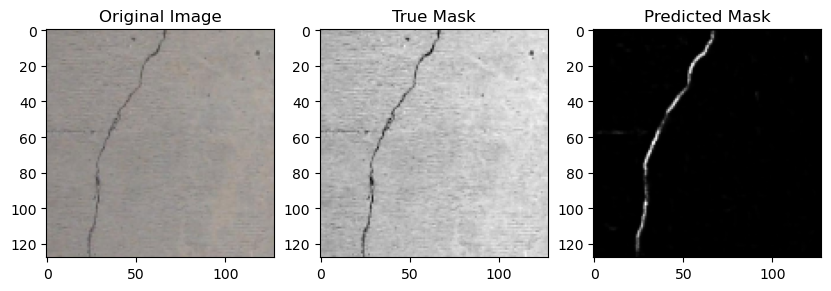

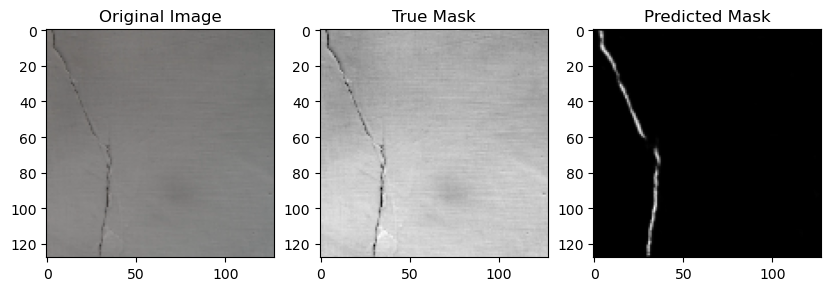

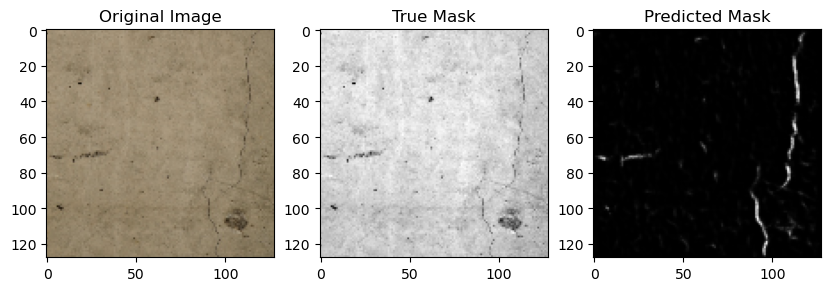

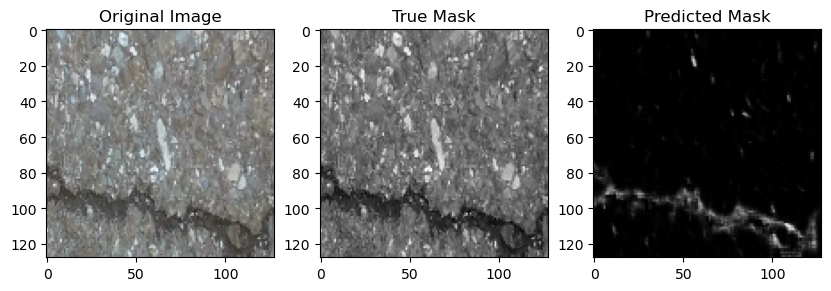

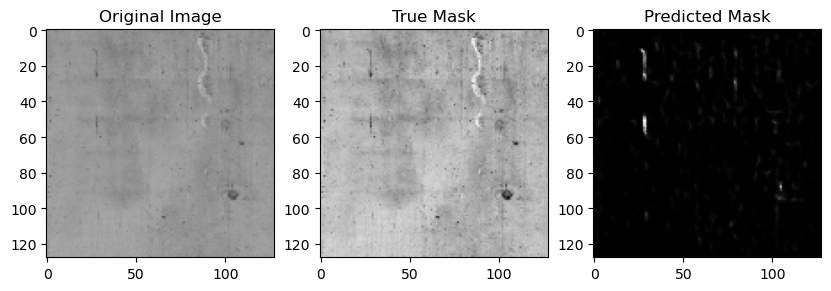

In [34]:
display_test_prediction(X_test,y_test,predictions,5)

### Fitting Curves to cracks.
Used CurveFit class defined in "../Task/src/curve_fit.py" to fir curves to masks of cracks.

In [35]:
random_mask_001 = load_single_mask("/home/recabet/Coding/Data/Test/masks/CRACK500_20160222_082414_1281_721.jpg")

In [36]:
fitter=CurveFit()

Linear function (polynomial of degree 1).

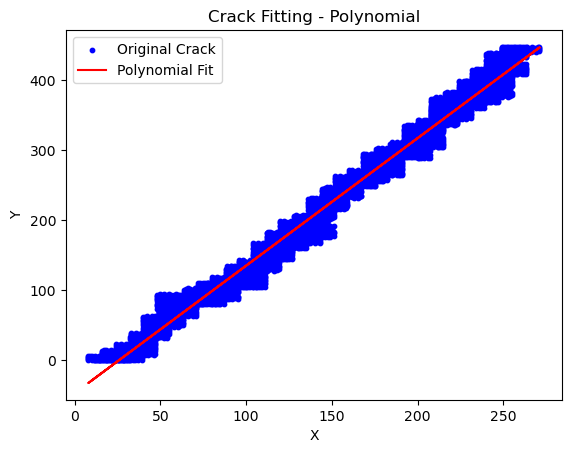

Polynomial coefficients: [  1.81784608 -46.60927318]


In [37]:
fitter.fit_crack_function(random_mask_001,"polynomial",1,True)

In [40]:
random_mask_002=load_single_mask("/home/recabet/Coding/Data/Test/masks/CRACK500_20160222_115233_1921_721.jpg")

Sine-cosine superposition,had some scaling issues.

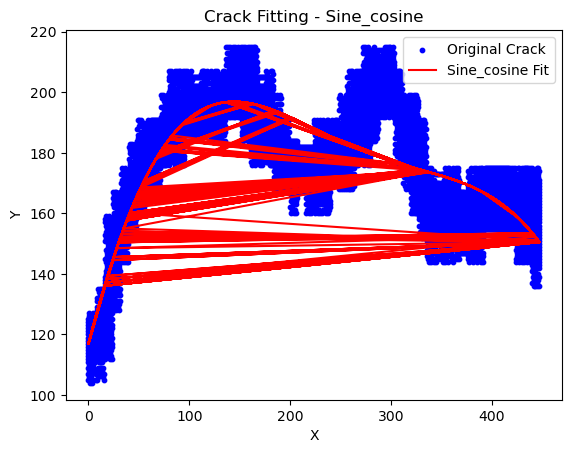

Sine-Cosine parameters: [ 9.66782778e+03  7.57251537e-03 -4.42113417e-01  9.48633686e+03
  7.65110873e-03  1.10586940e+00]


In [54]:
fitter.fit_crack_function(random_mask_002,"sine_cosine",plot=True)

In [44]:
random_mask_003=load_single_mask("/home/recabet/Coding/Data/Test/masks/CRACK500_20160222_115219_641_1.jpg")

Polynomial of degree 2.

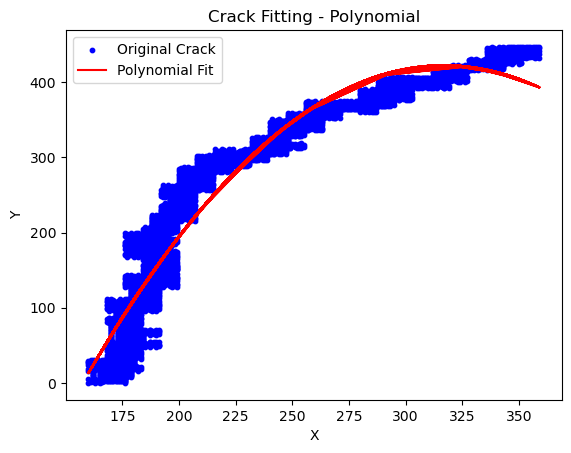

Polynomial coefficients: [-1.66169178e-02  1.05333691e+01 -1.24665466e+03]


In [45]:
fitter.fit_crack_function(random_mask_003,"polynomial",2,plot=True)

### Generating synthetic images
Used ImageGenerator class defined in "../Task/src/synthetic_images.py" to generate user made random images with sine-cosine and or circlular cracks.

In [46]:
synthetic_gen=ImageGenerator((128,128))

In [47]:
regular_images=synthetic_gen.create_synthetic_images(8)
composite_images=synthetic_gen.create_composite_synthetic_images(8)

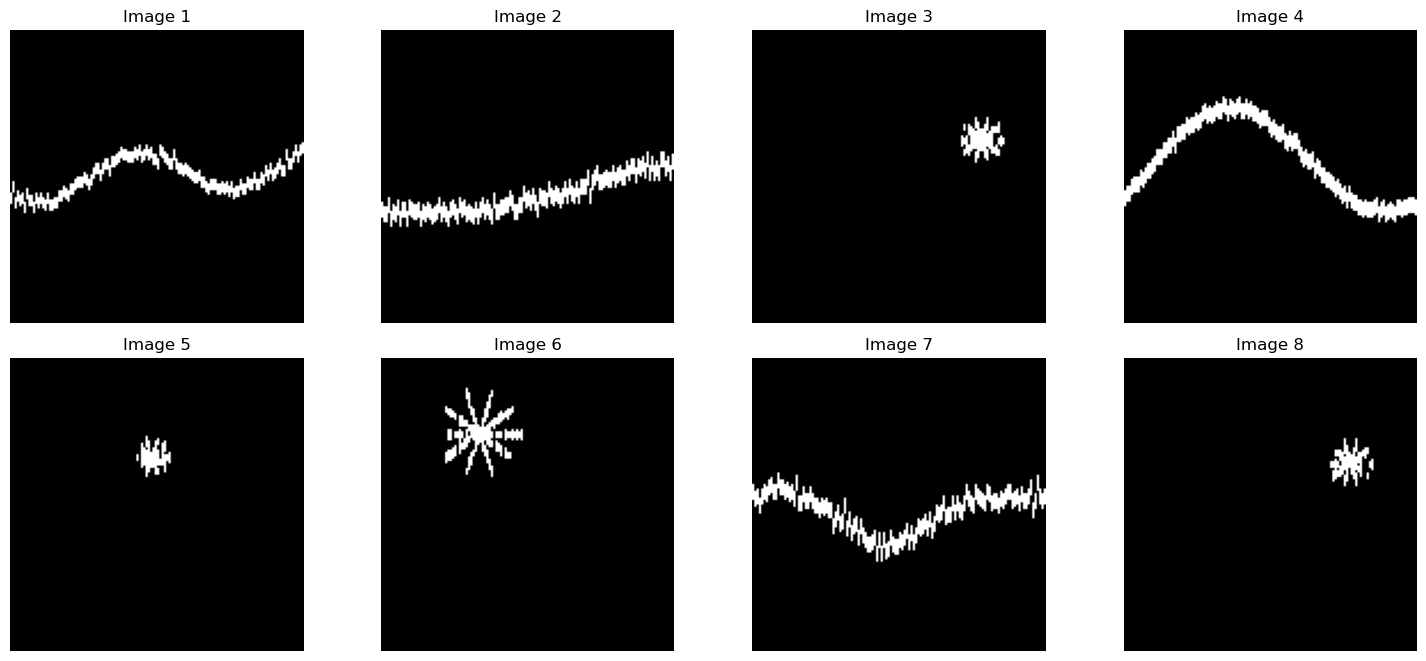

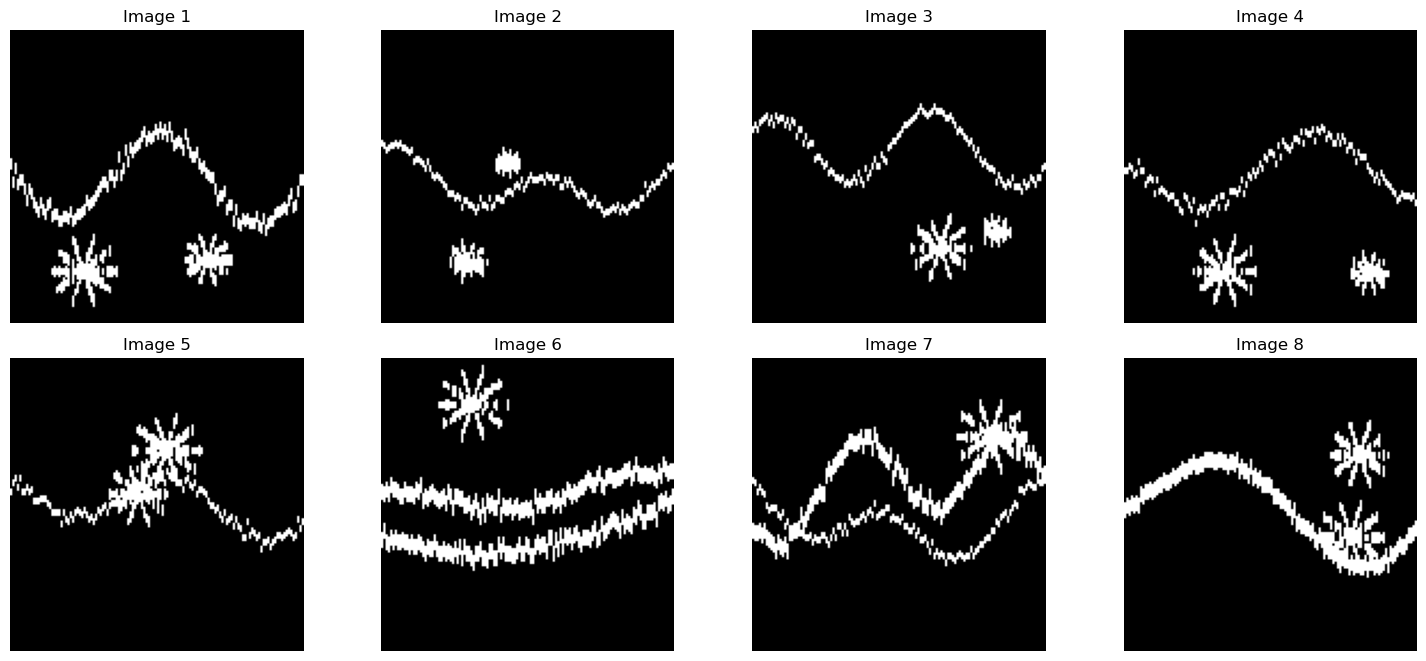

In [48]:
synthetic_gen.display_images(regular_images)
synthetic_gen.display_images(composite_images)

### Inverse task.
Used the same fitter to fit functions to the synthectic cracks.

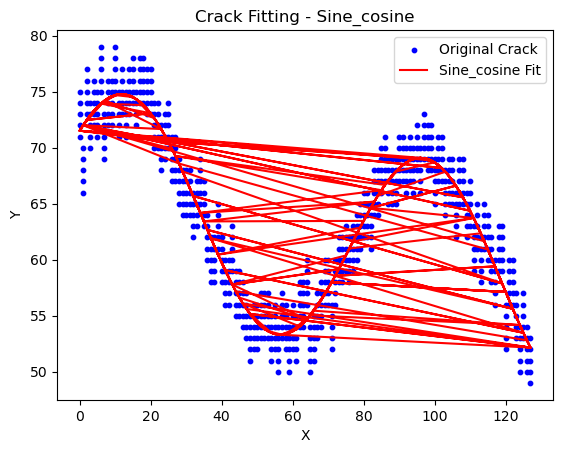

Sine-Cosine parameters: [9.29980344e+00 7.44878991e-02 5.97317315e-01 9.34771617e+01
 9.73910056e-04 7.82504015e-01]


In [49]:
fitter.fit_crack_function(regular_images[0],"sine_cosine",plot=True)

The parameters of the sine fuction match.
The discrepency of the cosine may be because of the scaling,noise or overfitting of the curve_fit.

In [50]:
print(f"Synthetic image generator sine-cosine params:\n"
      f"amplitudes: {synthetic_gen.get_amplitudes()[0]}\n"
      f"frequencies: {synthetic_gen.get_frequencies()[0]}\n"
      f"phases: {synthetic_gen.get_phases()[0]}\n")
print(f"Curve-fitter sine-cosine params:\n"
      f"amplitudes: {fitter.get_amplitudes()}\n"
      f"frequencies: {fitter.get_frequencies()}\n"
      f"phases: {fitter.get_phases()}\n")

Synthetic image generator sine-cosine params:
amplitudes: (9.534988589477596, 7.2013383622566955)
frequencies: (0.07482920440979424, 0.01001029373356104)
phases: (0.5801805019369202, 1.1703074234403459)

Curve-fitter sine-cosine params:
amplitudes: (9.299803441888889, 93.47716169436059)
frequencies: (0.07448789913569383, 0.0009739100557175053)
phases: (0.5973173149171264, 0.7825040151122639)



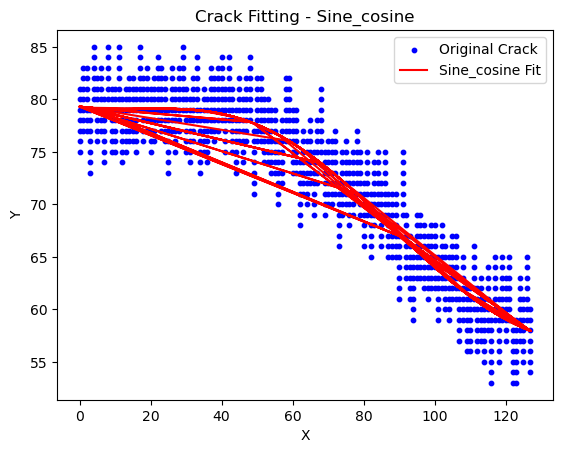

Sine-Cosine parameters: [ 3.68248885e+00  4.48227326e-02 -8.01623426e-01  8.06588526e+02
  1.99702001e-04  1.46900538e+00]


In [51]:
fitter.fit_crack_function(regular_images[1],"sine_cosine",plot=True)

In [52]:
print(f"Synthetic image generator sine-cosine params:\n"
      f"amplitudes: {synthetic_gen.get_amplitudes()[1]}\n"
      f"frequencies: {synthetic_gen.get_frequencies()[1]}\n"
      f"phases: {synthetic_gen.get_phases()[1]}\n")

Synthetic image generator sine-cosine params:
amplitudes: (10.34695520181005, 6.429617159599948)
frequencies: (0.018587732372790572, 0.024598495930345972)
phases: (0.9001480153757413, 5.849726782991984)

